## Import Libraries

In [1]:
# read hdf5 file and plot the data
import h5py
import xmltodict
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import plotly.express as px
# raise SystemExit("Stop Point!")

## Load Data

In [2]:
# read the file
datafile_path = "../../data/"
# filename = datafile_path + "eye closed2023.11.29_11.05.35.hdf5"
# filename = datafile_path + "eye open2023.11.29_10.56.28.hdf5"
filename = datafile_path + "eyes closed2024.03.11_12.29.58.hdf5"

def read_hdf5(filename):
    with h5py.File(filename, "r") as FILE:
        # Print all root level object names (aka keys) 
        # these can be group or dataset names 
        print("Keys: %s" % FILE.keys())

        # List all the groups in the file
        print("\nGroups in the HDF5 file:")
        print(list(FILE.keys()))

        # Print all the groups and datasets
        print("\nGroups and datasets in the HDF5 file:")
        for key in FILE.keys():
            print(key, FILE[key])
        # Print al the datasets in the RawData group
        print("\nDatasets in the RawData group:")
        print(list(FILE['RawData'].keys()))

        # Access a specific group
        data_samples = FILE['RawData']['Samples'][:]
        data_task_description = FILE['RawData']['AcquisitionTaskDescription'][:]
        # data_info[0] is a xml format string, convert it to to dictionary using xmltodict
        data_info_dict = xmltodict.parse(data_task_description[0])
        FILE.close()
        return data_samples, data_info_dict

data_samples, data_info_dict = read_hdf5(filename)

Keys: <KeysViewHDF5 ['AsynchronData', 'RawData', 'SavedFeatues', 'Version']>

Groups in the HDF5 file:
['AsynchronData', 'RawData', 'SavedFeatues', 'Version']

Groups and datasets in the HDF5 file:
AsynchronData <HDF5 group "/AsynchronData" (1 members)>
RawData <HDF5 group "/RawData" (7 members)>
SavedFeatues <HDF5 group "/SavedFeatues" (1 members)>
Version <HDF5 group "/Version" (1 members)>

Datasets in the RawData group:
['AcquisitionTaskDescription', 'DAQDeviceCapabilities', 'DAQDeviceDescription', 'ElectrodeMontageDefinition', 'Samples', 'SessionDescription', 'SubjectDescription']


### Acquisition Task Description

In [3]:
data_info_dict

{'AcquisitionTaskDescription': {'@xmlns:xsd': 'http://www.w3.org/2001/XMLSchema',
  '@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  'RecordingDateBegin': '2024-03-11T16:29:58.945627Z',
  'ChannelProperties': {'ChannelProperties': [{'BipolarPhysicalChannelNumber': '0',
     'SensitivityLowValue': '-2384.835',
     'SensitivityHighValue': '2384.835',
     'SampleRate': '512',
     'Offset': '12378.8652',
     'NotchFilter': '60',
     'HighpassFilter': '0.01',
     'LowpassFilter': '30',
     'IsBipolar': 'false',
     'IsTriggerChannel': 'false',
     'DeviceNumber': '1',
     'DeviceName': 'HA-2021.05.05',
     'LogicalChannelNumber': '1',
     'PhysicalChannelNumber': '1',
     'ChannelType': None,
     'ChannelName': 'FP1',
     'ChannelColoring': {'PenColor': '-16626564', 'PaperColor': '-1'}},
    {'BipolarPhysicalChannelNumber': '0',
     'SensitivityLowValue': '-250000',
     'SensitivityHighValue': '250000',
     'SampleRate': '512',
     'Offset': '0',
     'NotchFi

### Get the Channel Names

In [4]:
# data_info_dict is a dictionary, get all the ChannelName from it and convert it to a list, the ChannelName is under the key 'AcquisitionTaskDescription'/'ChannelProperties'/
channel_names = [channel['ChannelName'] for channel in data_info_dict['AcquisitionTaskDescription']['ChannelProperties']['ChannelProperties']]
np.array(channel_names)

array(['FP1', 'FPz', 'FP2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',
       'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1',
       'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz',
       'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2',
       'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4',
       'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2',
       'F9', 'F10', 'A1', 'A2'], dtype='<U3')

In [5]:
data_samples.shape

(92169, 64)

In [6]:
data_samples

array([[   2.5563848 ,    3.1822941 ,    1.2034978 , ...,   -2.9059842 ,
           0.71301997,   -2.5849085 ],
       [  68.73844   ,   89.077194  ,   26.457127  , ...,  -47.23534   ,
          56.808033  ,  -46.849823  ],
       [ 414.78625   ,  537.08344   ,  161.33191   , ..., -246.12265   ,
         371.77872   , -249.87402   ],
       ...,
       [  -7.1533203 ,   -4.6777344 ,  -20.655762  , ...,   17.849121  ,
           8.711914  ,   18.77246   ],
       [  -5.0844727 ,   -2.5048828 ,  -18.467285  , ...,   20.879395  ,
          11.341797  ,   20.711914  ],
       [  -7.845703  ,   -5.036133  ,  -20.8042    , ...,   19.214355  ,
           9.703125  ,   18.05664   ]], dtype=float32)

### Initialize the parameters

In [7]:
# Set the parameters
time_to_remove = 60             # seconds
sampling_rate = 512             # Hz
data_samples = data_samples[sampling_rate*time_to_remove:]  # Remove the first x data points
data_shape = data_samples.shape # (samples, channels)
duration = data_shape[0] / 512  # seconds
channels = data_shape[1]        # channelss
num_samples = data_shape[0]     # samples
print(f"Data shape: {data_shape}, Sampling rate: {sampling_rate} Hz, Duration: {duration} seconds, Channels: {channels}")

# Generate time array
time = np.arange(0, duration, 1 / sampling_rate)

# Create a pandas DataFrame from the data
raw_data_df = pd.DataFrame(data_samples, columns=channel_names)
raw_data_df['Time'] = time
raw_data_df.head()

Data shape: (61449, 64), Sampling rate: 512 Hz, Duration: 120.017578125 seconds, Channels: 64


FP1         FPz         FP2         AF7         AF3         AF4  \
0  273.796875  370.140625  118.285156  186.179688  161.148438 -634.703125   
1  272.765625  367.421875  115.765625  185.339844  158.042969 -637.796875   
2  277.671875  370.875000  119.691406  190.773438  161.562500 -634.937500   
3  277.296875  369.390625  118.953125  190.953125  160.304688 -637.062500   
4  277.289062  368.414062  118.832031  191.136719  159.347656 -638.359375   

          AF8          F7         F5         F3  ...         PO4       PO8  \
0 -324.710938  405.906250 -91.398438 -33.947266  ... -208.457031  3.293945   
1 -328.046875  403.546875 -95.501953 -38.064453  ... -211.585938 -0.803711   
2 -325.351562  408.625000 -91.988281 -35.371094  ... -209.386719  0.835938   
3 -327.554688  409.593750 -92.255859 -37.028320  ... -212.132812 -2.510742   
4 -329.109375  410.078125 -92.152344 -38.027344  ... -214.789062 -5.310547   

           O1        Oz          O2         F9         F10          A1  \
0  -99.082031 -4139.875 -1093.43750 -33.711060 -178.562500  238.773438   
1 -100.056641 -4147.000 -1093.71875 -35.734375 -182.390625  235.351562   
2 -100.843750 -4152.875 -1093.84375 -33.045654 -180.148438  237.679688   
3 -101.689453 -4158.000 -1094.09375 -36.385986 -182.617188  234.843750   
4 -102.587891 -4162.500 -1094.53125 -38.829468 -184.382812  232.687500   

           A2      Time  
0 -206.910156  0.000000  
1 -210.613281  0.001953  
2 -208.207031  0.003906  
3 -210.703125  0.005859  
4 -212.648438  0.007812  

[5 rows x 65 columns]

## Pass the dataframes to MNE

In [8]:
# Change the data units from microvolts to volts
data_samples = np.divide(data_samples,1e6)

# Pass the dataframes to MNE
info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types='eeg')
raw_data = mne.io.RawArray(data_samples.T, info)


Creating RawArray with float64 data, n_channels=64, n_times=61449
    Range : 0 ... 61448 =      0.000 ...   120.016 secs
Ready.


## Plotting Functions

In [9]:
# Plot using plotly express
def plot_Plotly_Express(data_df, title, labels):
    fig = px.line(
        data_df, 
        x='Time', 
        y=data_df.columns, 
        title=title,
        labels=labels)
    fig.show()
    # fig.write_html(f"{title}.html")

# Plot using PyPlot
def plot_PyPlot(data_df, title, x_label, y_label):
    plt.figure(figsize=(16, 15))
    plt.plot(data_df['Time'], data_df.drop(columns=['Time']))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(data_df.columns, loc="best", prop={'size': 8})
    plt.show()

## Plot Raw EEG Data

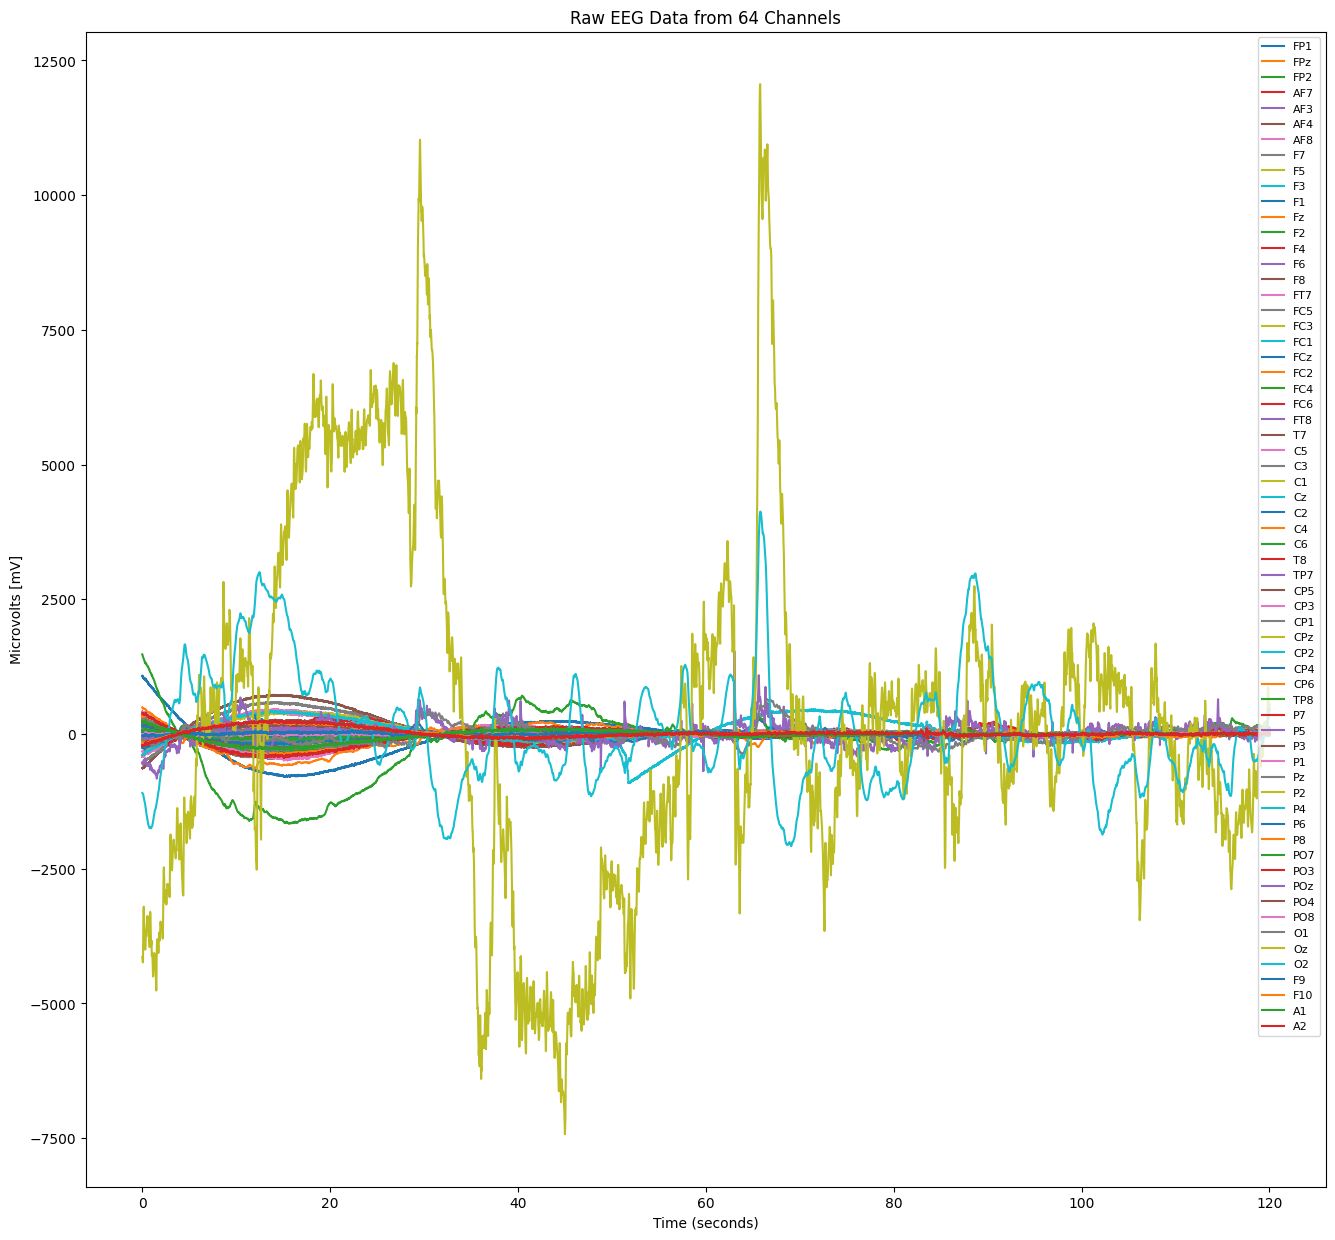

In [10]:
# Set the start and end time for the plot
raw_data_plot = raw_data_df[(raw_data_df['Time']>=0) & (raw_data_df['Time']<=360)]
# Plot raw EEG data using plotly express
# plot_Plotly_Express(raw_data_plot, f'Raw EEG Data from {channels} Channels', {'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})
# Plot raw EEG data using pyplot
plot_PyPlot(raw_data_plot, f'Raw EEG Data from {channels} Channels', 'Time (seconds)', 'Microvolts [mV]')

In [11]:
raw_data_df

FP1         FPz         FP2         AF7         AF3         AF4  \
0      273.796875  370.140625  118.285156  186.179688  161.148438 -634.703125   
1      272.765625  367.421875  115.765625  185.339844  158.042969 -637.796875   
2      277.671875  370.875000  119.691406  190.773438  161.562500 -634.937500   
3      277.296875  369.390625  118.953125  190.953125  160.304688 -637.062500   
4      277.289062  368.414062  118.832031  191.136719  159.347656 -638.359375   
...           ...         ...         ...         ...         ...         ...   
61444   -4.698242   -2.100586  -17.947754   20.985596   -0.174561   13.966797   
61445   -8.475098   -6.029297  -21.964844   18.084473   -4.134766   10.070312   
61446   -7.153320   -4.677734  -20.655762   20.341553   -2.635986   10.751953   
61447   -5.084473   -2.504883  -18.467285   23.175537   -0.160645   11.779297   
61448   -7.845703   -5.036133  -20.804199   20.702148   -2.395508    8.025391   

              AF8          F7         F5         F3  ...         PO4  \
0     -324.710938  405.906250 -91.398438 -33.947266  ... -208.457031   
1     -328.046875  403.546875 -95.501953 -38.064453  ... -211.585938   
2     -325.351562  408.625000 -91.988281 -35.371094  ... -209.386719   
3     -327.554688  409.593750 -92.255859 -37.028320  ... -212.132812   
4     -329.109375  410.078125 -92.152344 -38.027344  ... -214.789062   
...           ...         ...        ...        ...  ...         ...   
61444   27.526855   -4.741699   1.024170  -0.220955  ...   15.990234   
61445   23.101196   -7.129883  -1.960693  -3.827671  ...   14.181641   
61446   23.435303   -3.770020   0.914795  -1.838821  ...   16.968750   
61447   24.372925    0.641602   5.016113   1.143143  ...   20.464844   
61448   20.846069   -0.158691   4.306641  -0.746643  ...   19.050781   

             PO8          O1          Oz           O2         F9         F10  \
0       3.293945  -99.082031 -4139.87500 -1093.437500 -33.711060 -178.562500   
1      -0.803711 -100.056641 -4147.00000 -1093.718750 -35.734375 -182.390625   
2       0.835938 -100.843750 -4152.87500 -1093.843750 -33.045654 -180.148438   
3      -2.510742 -101.689453 -4158.00000 -1094.093750 -36.385986 -182.617188   
4      -5.310547 -102.587891 -4162.50000 -1094.531250 -38.829468 -184.382812   
...          ...         ...         ...          ...        ...         ...   
61444  34.707031  105.916016   512.28125   458.562500   9.734009   20.074219   
61445  33.485352  105.528320   521.25000   460.265625   6.065796   15.933594   
61446  37.215820  105.081055   531.25000   461.375000   7.810547   17.849121   
61447  41.172852  104.690430   542.09375   461.781250  10.661377   20.879395   
61448  39.607422  104.208008   553.18750   461.265625   9.067871   19.214355   

               A1          A2        Time  
0      238.773438 -206.910156    0.000000  
1      235.351562 -210.613281    0.001953  
2      237.679688 -208.207031    0.003906  
3      234.843750 -210.703125    0.005859  
4      232.687500 -212.648438    0.007812  
...           ...         ...         ...  
61444   11.790039   22.178711  120.007812  
61445    7.410156   17.755859  120.009766  
61446    8.711914   18.772461  120.011719  
61447   11.341797   20.711914  120.013672  
61448    9.703125   18.056641  120.015625  

[61449 rows x 65 columns]

## Manually Remove the Channels

In [12]:
# Remove channels from the data 
def remove_channels(data_samples, raw_data_df, channels, channel_names, channels_to_remove):
    # Get the index of the channels to remove
    channels_to_remove_index = [channel_names.index(channel) for channel in channels_to_remove]
    # Remove the channels from the data_samples
    data_samples = np.delete(data_samples, channels_to_remove_index, axis=1)
    # Remove the channels from the raw_data
    raw_data_df = raw_data_df.drop(columns=channels_to_remove)
    # Remove the channels from the channel_names
    channel_names = [channel for channel in channel_names if channel not in channels_to_remove]
    # Change the number of channels
    channels = channels - len(channels_to_remove)
    return data_samples, raw_data_df, channels, channel_names

# Channels to remove
channels_to_remove = ['Cz', 'O1', 'PO7', 'POz', 'Oz', 'O2']
# Remove the channels
data_samples, raw_data_df, channels, channel_names = \
    remove_channels(data_samples, raw_data_df, channels, channel_names, channels_to_remove)

# Pass the updated dataframes to MNE
info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types='eeg')
raw_data = mne.io.RawArray(data_samples.T, info)

Creating RawArray with float64 data, n_channels=58, n_times=61449
    Range : 0 ... 61448 =      0.000 ...   120.016 secs
Ready.


In [13]:
data_samples.shape

(61449, 58)

In [14]:
raw_data_df

FP1         FPz         FP2         AF7         AF3         AF4  \
0      273.796875  370.140625  118.285156  186.179688  161.148438 -634.703125   
1      272.765625  367.421875  115.765625  185.339844  158.042969 -637.796875   
2      277.671875  370.875000  119.691406  190.773438  161.562500 -634.937500   
3      277.296875  369.390625  118.953125  190.953125  160.304688 -637.062500   
4      277.289062  368.414062  118.832031  191.136719  159.347656 -638.359375   
...           ...         ...         ...         ...         ...         ...   
61444   -4.698242   -2.100586  -17.947754   20.985596   -0.174561   13.966797   
61445   -8.475098   -6.029297  -21.964844   18.084473   -4.134766   10.070312   
61446   -7.153320   -4.677734  -20.655762   20.341553   -2.635986   10.751953   
61447   -5.084473   -2.504883  -18.467285   23.175537   -0.160645   11.779297   
61448   -7.845703   -5.036133  -20.804199   20.702148   -2.395508    8.025391   

              AF8          F7         F5         F3  ...          P6  \
0     -324.710938  405.906250 -91.398438 -33.947266  ... -262.550781   
1     -328.046875  403.546875 -95.501953 -38.064453  ... -262.699219   
2     -325.351562  408.625000 -91.988281 -35.371094  ... -262.714844   
3     -327.554688  409.593750 -92.255859 -37.028320  ... -262.886719   
4     -329.109375  410.078125 -92.152344 -38.027344  ... -263.304688   
...           ...         ...        ...        ...  ...         ...   
61444   27.526855   -4.741699   1.024170  -0.220955  ...   45.820312   
61445   23.101196   -7.129883  -1.960693  -3.827671  ...   46.531250   
61446   23.435303   -3.770020   0.914795  -1.838821  ...   47.300781   
61447   24.372925    0.641602   5.016113   1.143143  ...   48.150391   
61448   20.846069   -0.158691   4.306641  -0.746643  ...   48.755859   

               P8         PO3         PO4        PO8         F9         F10  \
0      494.031250  380.421875 -208.457031   3.293945 -33.711060 -178.562500   
1      493.062500  376.453125 -211.585938  -0.803711 -35.734375 -182.390625   
2      492.171875  378.726562 -209.386719   0.835938 -33.045654 -180.148438   
3      491.078125  376.132812 -212.132812  -2.510742 -36.385986 -182.617188   
4      489.796875  374.179688 -214.789062  -5.310547 -38.829468 -184.382812   
...           ...         ...         ...        ...        ...         ...   
61444   26.937500    1.122559   15.990234  34.707031   9.734009   20.074219   
61445   26.951172   -1.394531   14.181641  33.485352   6.065796   15.933594   
61446   26.832031    1.753906   16.968750  37.215820   7.810547   17.849121   
61447   26.595703    5.990723   20.464844  41.172852  10.661377   20.879395   
61448   26.052734    5.670898   19.050781  39.607422   9.067871   19.214355   

               A1          A2        Time  
0      238.773438 -206.910156    0.000000  
1      235.351562 -210.613281    0.001953  
2      237.679688 -208.207031    0.003906  
3      234.843750 -210.703125    0.005859  
4      232.687500 -212.648438    0.007812  
...           ...         ...         ...  
61444   11.790039   22.178711  120.007812  
61445    7.410156   17.755859  120.009766  
61446    8.711914   18.772461  120.011719  
61447   11.341797   20.711914  120.013672  
61448    9.703125   18.056641  120.015625  

[61449 rows x 59 columns]

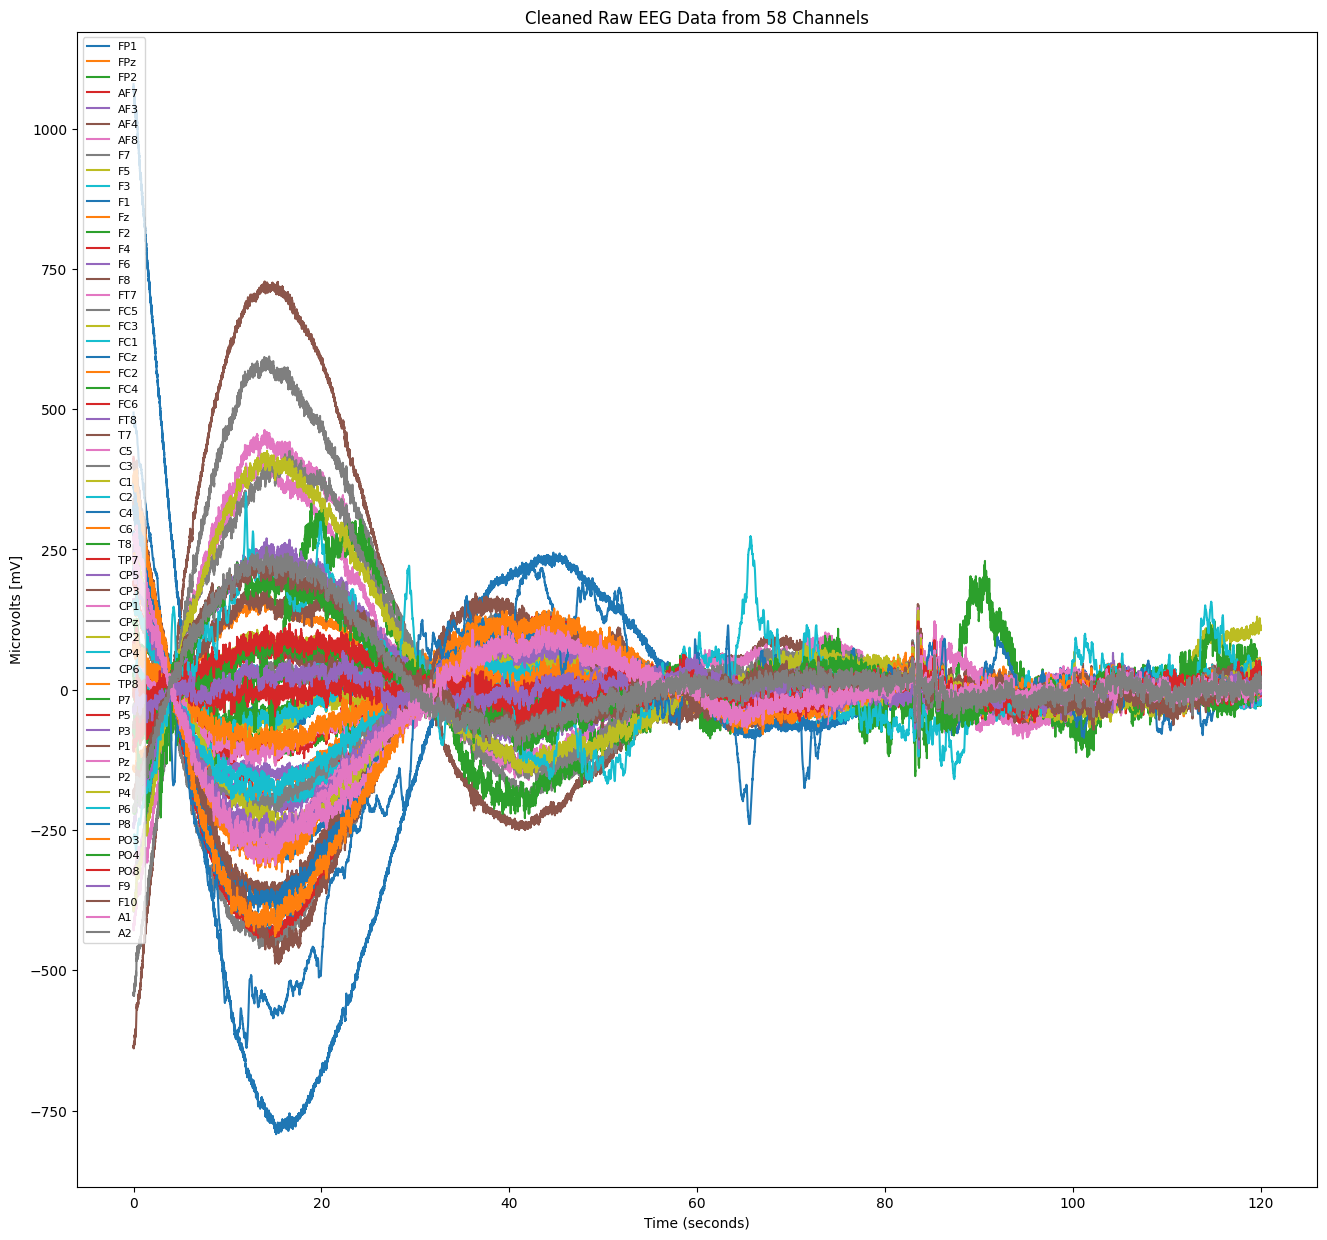

In [15]:
# Set the start and end time for the plot
raw_data_plot = raw_data_df[(raw_data_df['Time']>=0) & (raw_data_df['Time']<=360)]
# Plot raw EEG data using plotly express
# plot_Plotly_Express(raw_data_plot, f'Raw EEG Data from {channels} Channels', {'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})
# Plot raw EEG data using pyplot
plot_PyPlot(raw_data_plot, f'Updated Raw EEG Data from {channels} Channels', 'Time (seconds)', 'Microvolts [mV]')

In [16]:
raw_data

<RawArray | 58 x 61449 (120.0 s), ~27.2 MB, data loaded>

## Apply Re-referencing

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


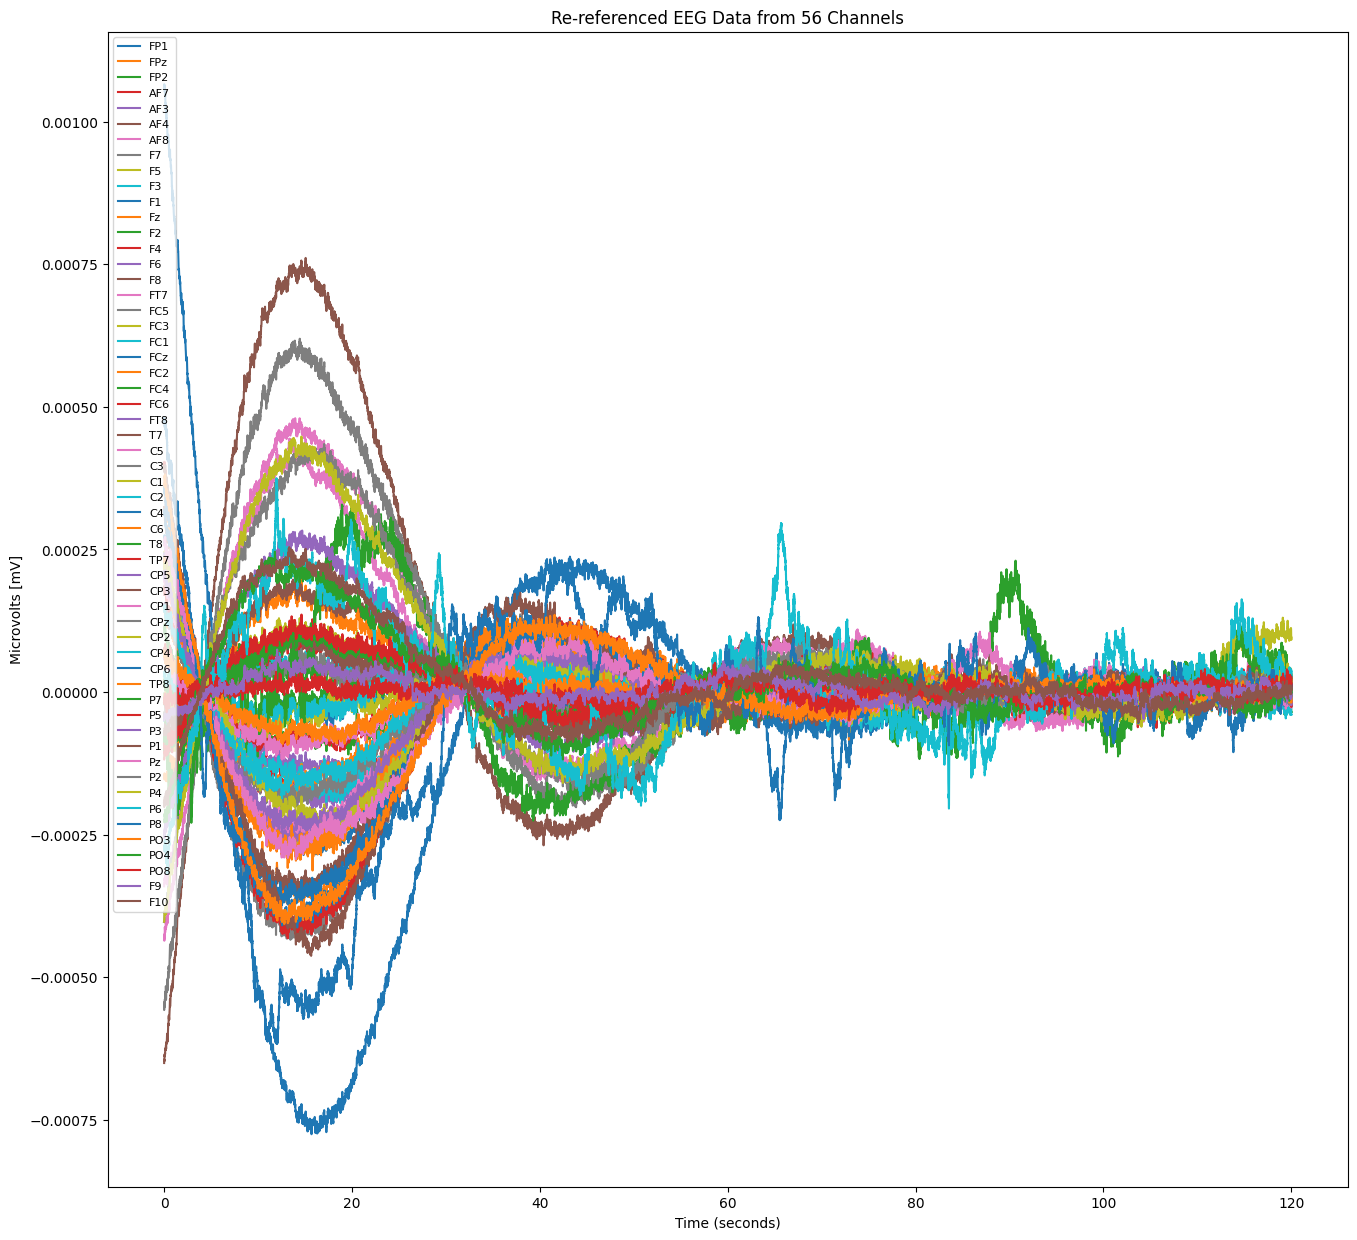

In [17]:
# Apply re-referencing to the data, using channel 63 and 64 as reference
reference_channels = ['A1', 'A2']
raw_data.set_eeg_reference(ref_channels=reference_channels)
raw_data_df_ref = pd.DataFrame(raw_data.get_data().T, columns=channel_names)
raw_data_df_ref['Time'] = time

# Drop the reference channels from the dataframe
raw_data_df_ref = raw_data_df_ref.drop(columns=reference_channels)
channels = channels - len(reference_channels)

# Set the start and end time for the plot
raw_data_df_ref_plot = raw_data_df_ref[(raw_data_df_ref['Time']>=0) & (raw_data_df_ref['Time']<=360)]

# Plot re-referenced EEG data using plotly express
# plot_Plotly_Express(raw_data_df_ref_plot, f'Re-referenced EEG Data from {channels} Channels', {'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})
# Plot re-referenced EEG data using pyplot
plot_PyPlot(raw_data_df_ref_plot, f'Re-referenced EEG Data from {channels} Channels', 'Time (seconds)', 'Microvolts [mV]')

## Apply Band-pass Filter

In [18]:
# Apply a bandpass filter to the data using MNE
band_filtered_eeg = raw_data.filter(l_freq=0.1, h_freq=30, fir_design="firwin")
band_data = band_filtered_eeg.get_data()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


## Plot Band-pass Filtered Data

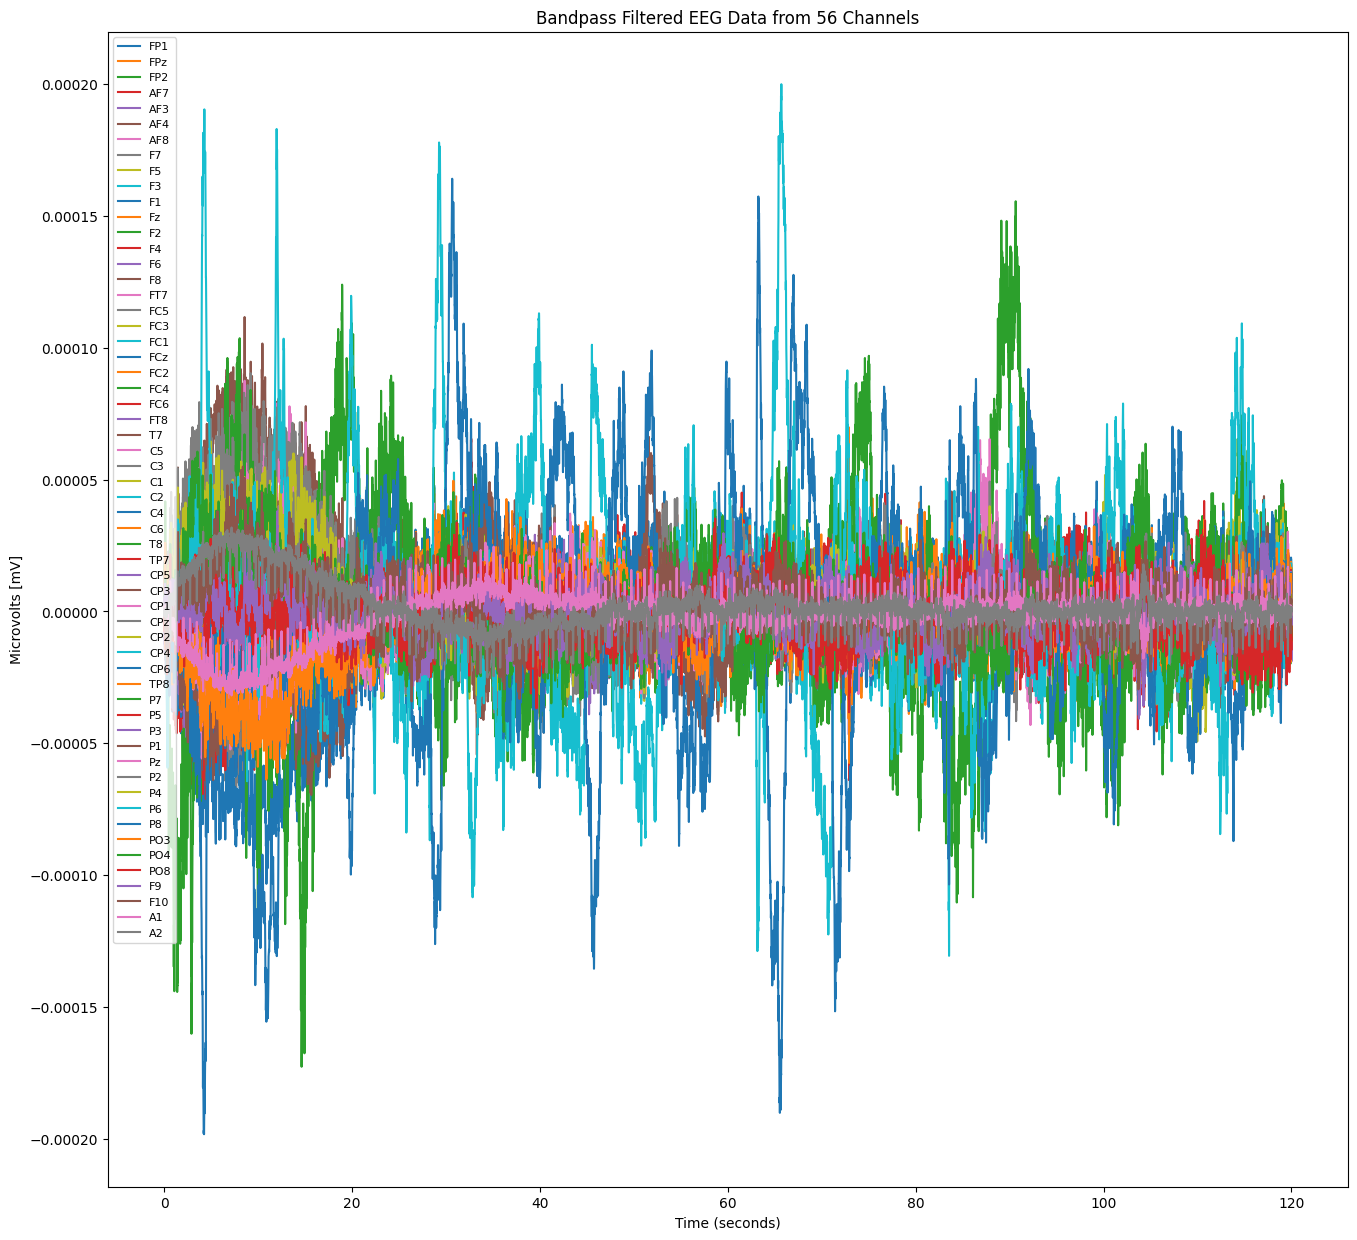

In [19]:
# Create a pandas DataFrame from the bandpass filtered data
band_data_df = pd.DataFrame(band_data.T, columns=channel_names)
band_data_df['Time'] = band_filtered_eeg.times
# Set the start and end time for the plot
band_data_df_plot = band_data_df[(band_data_df['Time']>=0) & (band_data_df['Time']<=360)]
# Plot the filtered EEG data using plotly express
# plot_Plotly_Express(band_data_df_plot, f'Bandpass Filtered EEG Data from {channels} Channels', {'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})
# Plot the bandpass filtered EEG data using pyplot
plot_PyPlot(band_data_df_plot, f'Bandpass Filtered EEG Data from {channels} Channels', 'Time (seconds)', 'Microvolts [mV]')

## Apply Notch Filter

In [20]:
# Apply notch filter to the data using MNE
notch_filtered_eeg = band_filtered_eeg.notch_filter(freqs=60)
notch_data = notch_filtered_eeg.get_data()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.0s finished


## Plot Notch Filtered Data

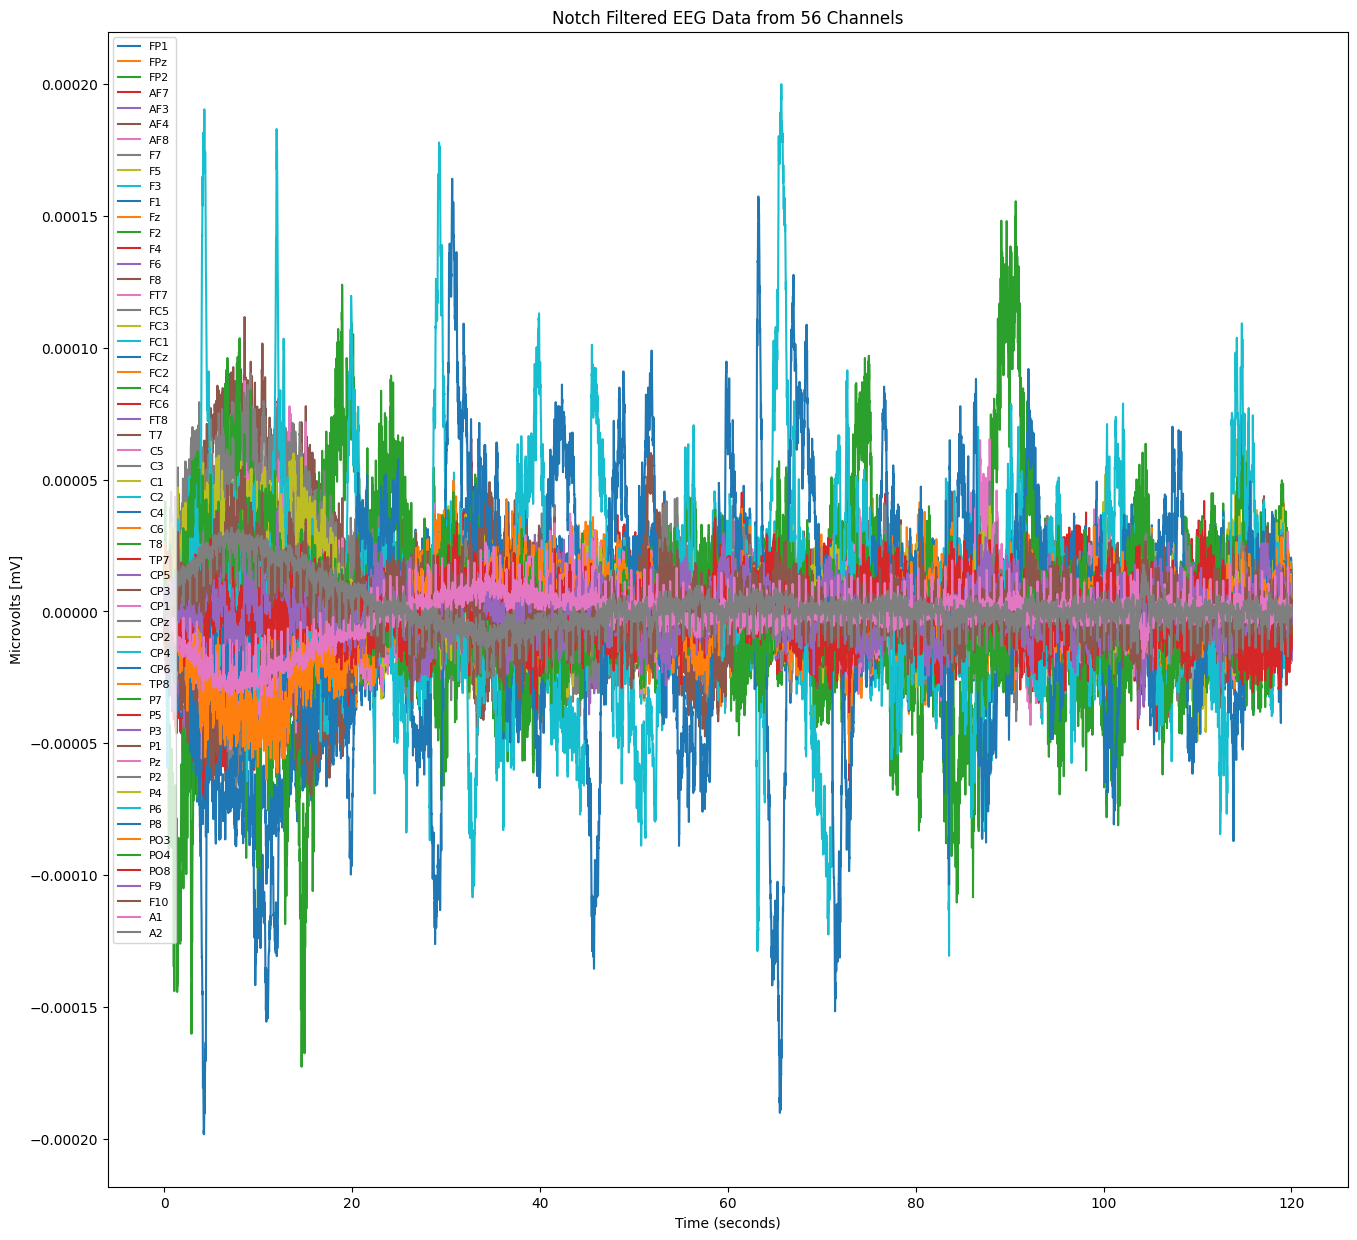

In [21]:
# Format the notch filtered data into a pandas DataFrame
notch_data_df = pd.DataFrame(notch_data.T, columns=channel_names)
notch_data_df['Time'] = notch_filtered_eeg.times

# Plot the notch filtered EEG data using plotly express
# plot_Plotly_Express(notch_data_df, 0, 120, f'Notch Filtered EEG Data from {channels} Channels', {'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})

# Plot the notch filtered EEG data using pyplot
plot_PyPlot(notch_data_df, f'Notch Filtered EEG Data from {channels} Channels', 'Time (seconds)', 'Microvolts [mV]')

## Independent Component Analysis (ICA)

Fitting ICA to data using 58 channels (please be patient, this may take a while)
Selecting by number: 56 components


Fitting ICA took 2.8s.
Creating RawArray with float64 data, n_channels=56, n_times=61449
    Range : 0 ... 61448 =      0.000 ...   120.016 secs
Ready.
Using matplotlib as 2D backend.


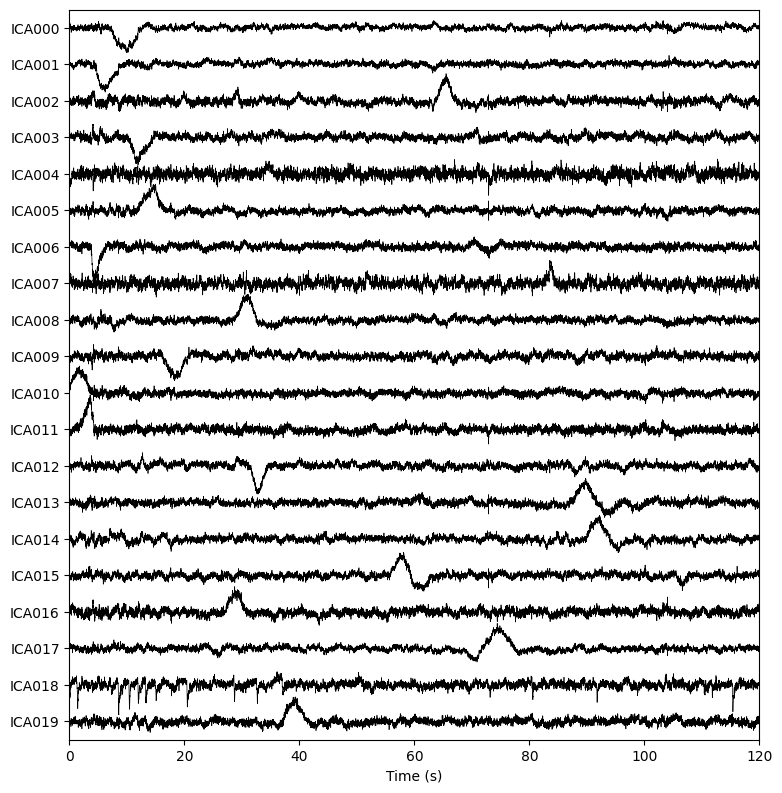

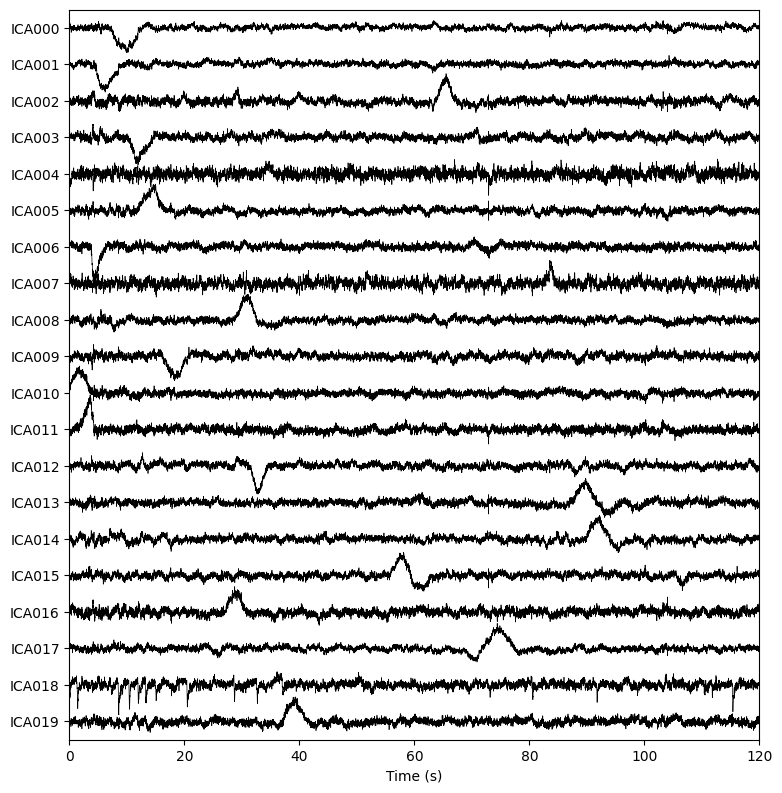

In [22]:
# Apply ICA to the data using MNE https://mne.tools/stable/generated/mne.preprocessing.ICA.html 
ica = mne.preprocessing.ICA(n_components=channels, random_state=97, max_iter="auto")
ica.fit(notch_filtered_eeg)
ica.plot_sources(notch_filtered_eeg, show_scrollbars=False, start=0, stop=num_samples)

In [23]:
ica

<ICA | raw data decomposition, method: fastica (fit in 44 iterations on 61449 samples), 56 ICA components (58 PCA components available), channel types: eeg, no sources marked for exclusion>

## Remove the EOG artifacts

In [24]:
# # Remove the EOG artifacts from the data using MNE
# eog_indices, eog_scores = ica.find_bads_eog(notch_filtered_eeg)
# ica.plot_scores(eog_scores)
# # No EOG channel(s) found

## Remove Artifact

Applying ICA to Raw instance
    Transforming to ICA space (56 components)
    Zeroing out 0 ICA components
    Projecting back using 58 PCA components


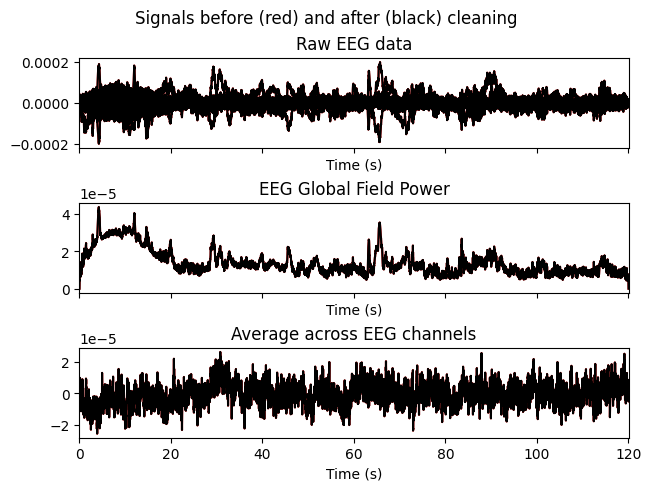

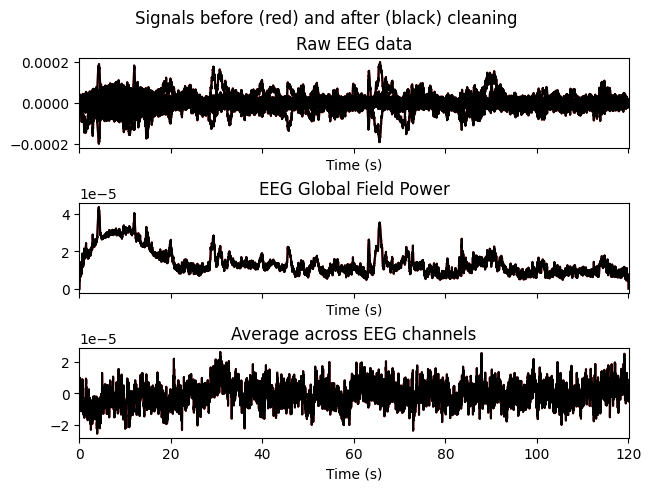

In [25]:
# blinks
exclude = []
ica.plot_overlay(notch_filtered_eeg, exclude=exclude, picks="eeg", start=0, stop=num_samples)

In [26]:
# Get Data that removed the specified components from the data using MNE
ica.exclude = exclude
cleaned_eeg = ica.apply(notch_filtered_eeg)
cleaned_eeg

Applying ICA to Raw instance
    Transforming to ICA space (56 components)
    Zeroing out 0 ICA components
    Projecting back using 58 PCA components


<RawArray | 58 x 61449 (120.0 s), ~27.2 MB, data loaded>

## Plot the cleaned EEG data

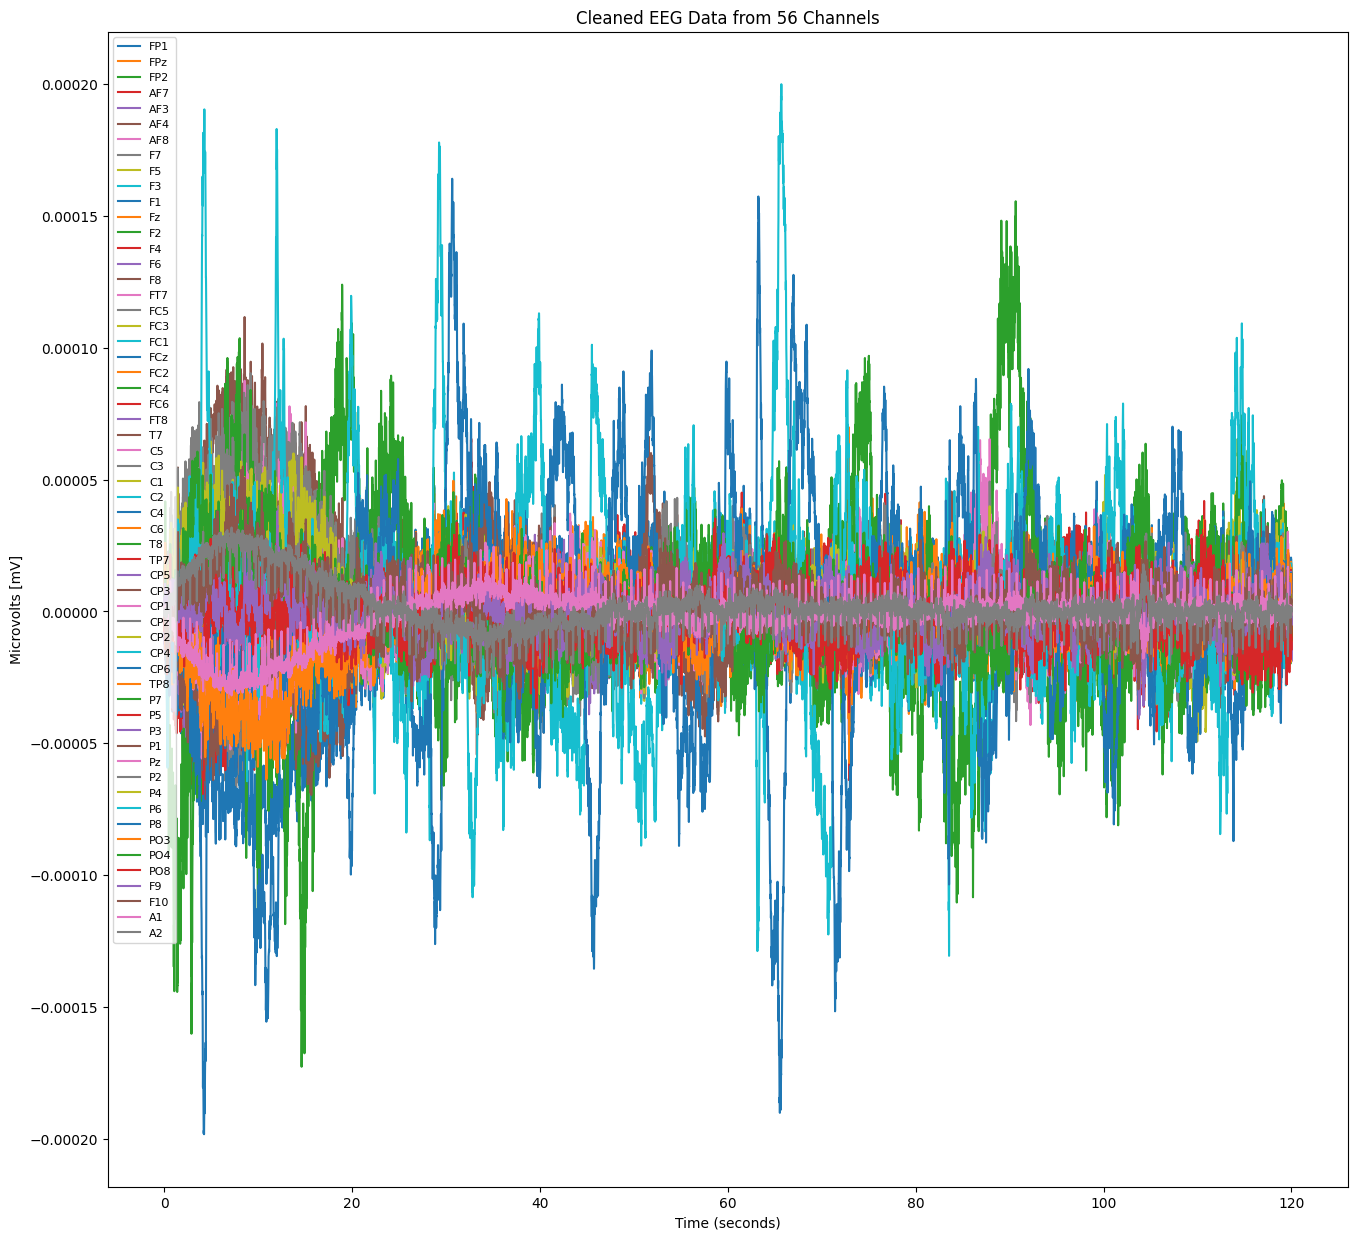

In [37]:
# Format the cleaned data into a pandas DataFrame
cleaned_data = cleaned_eeg.get_data()
cleaned_data_df = pd.DataFrame(cleaned_data.T, columns=channel_names)
cleaned_data_df['Time'] = cleaned_eeg.times 

# Plot the cleaned EEG data using plotly express
# plot_Plotly_Express(cleaned_data_df, f'Cleaned EEG Data from {channels} Channels', {'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})

# Plot the cleaned EEG data using pyplot
plot_PyPlot(cleaned_data_df, f'Cleaned EEG Data from {channels} Channels', 'Time (seconds)', 'Microvolts [mV]')

In [28]:
cleaned_data.shape

(58, 61449)

## Power Spectual Density

In [29]:
# Calculate the Power Spectral Density (PSD) of the cleaned EEG data 
# using MNE's mne.io.RawArray.compute_psd() method
# Two methods are used: Welch and Multitaper
welch_psd = cleaned_eeg.compute_psd(method='welch', fmin=0, fmax=30, n_fft=int(20*sampling_rate))
multitaper_psd = cleaned_eeg.compute_psd(method='multitaper', fmin=0, fmax=30)
welch_psd_df = welch_psd.to_data_frame(copy=True)
welch_psd

Effective window size : 20.000 (s)
    Using multitaper spectrum estimation with 7 DPSS windows


<Power Spectrum (from Raw, welch method) | 58 channels × 601 freqs, 0.0-30.0 Hz>

## Define Plotting Functions

In [30]:
# Plot the frequence band data from welch PSD using plotly express
def plot_Plotly_Express_PSD(data_df, title, labels):
    fig = px.line(
        data_df, 
        x='freq', 
        y=data_df.columns[1:], 
        title=title,
        labels=labels)
    fig.show()

# Plot the frequence band data from welch PSD using pyplot
def plot_PyPlot_PSD(data_df, title, x_label, y_label):
    plt.figure(figsize=(16, 16))
    plt.plot(data_df['freq'], data_df.iloc[:,1:])
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(data_df.columns[1:], loc="best", prop={'size': 8})
    plt.show()

# Initialize data with each frequency band
delta_band = welch_psd_df[(welch_psd_df['freq']>=0.5) & (welch_psd_df['freq']<4)]
theta_band = welch_psd_df[(welch_psd_df['freq']>=4) & (welch_psd_df['freq']<8)]
alpha_band = welch_psd_df[(welch_psd_df['freq']>=8) & (welch_psd_df['freq']<12)]
beta_band = welch_psd_df[(welch_psd_df['freq']>=12) & (welch_psd_df['freq']<30)]
low_beta_band = welch_psd_df[(welch_psd_df['freq']>=12) & (welch_psd_df['freq']<20)]
high_beta_band = welch_psd_df[(welch_psd_df['freq']>=20) & (welch_psd_df['freq']<30)]
gamma_band = welch_psd_df[(welch_psd_df['freq']>=30) & (welch_psd_df['freq']<=120)]

# Save the data to a pandas matrix, with each column representing a average frequency band, and each row representing a channel
welch_psd_matrix = np.array([delta_band.mean().values[1:], theta_band.mean().values[1:], alpha_band.mean().values[1:], beta_band.mean().values[1:], low_beta_band.mean().values[1:], high_beta_band.mean().values[1:]])
welch_psd_matrix_df = pd.DataFrame(welch_psd_matrix.T, index=welch_psd_df.columns[1:], columns=['Delta', 'Theta', 'Alpha', 'Beta', 'Low Beta', 'High Beta'])

welch_psd_matrix_df

Delta         Theta         Alpha          Beta      Low Beta  \
FP1  1.209680e-11  1.893291e-12  6.951553e-13  4.865375e-13  7.324458e-13   
FPz  1.125155e-11  1.797964e-12  6.776802e-13  3.521809e-13  5.873090e-13   
FP2  1.437249e-11  1.981728e-12  7.257183e-13  4.072860e-13  6.221068e-13   
AF7  1.056040e-11  1.885507e-12  7.856039e-13  4.725548e-13  7.291479e-13   
AF3  7.735074e-12  2.175315e-12  9.242535e-13  4.488745e-13  7.326640e-13   
AF4  8.688248e-12  2.405075e-12  1.070699e-12  5.140198e-13  8.290732e-13   
AF8  1.078492e-11  1.830457e-12  7.180903e-13  4.135445e-13  6.416685e-13   
F7   5.506156e-12  1.558155e-12  6.683391e-13  3.954182e-13  5.972772e-13   
F5   6.895230e-12  2.103927e-12  9.600583e-13  5.642715e-13  8.324788e-13   
F3   8.449272e-12  2.724634e-12  1.164254e-12  5.106397e-13  8.429669e-13   
F1   1.002048e-11  3.275427e-12  1.411687e-12  5.262346e-13  8.910473e-13   
Fz   1.096773e-11  3.603987e-12  1.579634e-12  5.521567e-13  9.474935e-13   
F2   1.038410e-11  3.444041e-12  1.523082e-12  5.804468e-13  9.685706e-13   
F4   9.430430e-12  3.055011e-12  1.352290e-12  6.361789e-13  9.894139e-13   
F6   7.308892e-12  2.392639e-12  1.156799e-12  8.367385e-13  1.082938e-12   
F8   5.903947e-12  1.533864e-12  7.905700e-13  7.255739e-13  1.047262e-12   
FT7  4.561472e-12  1.367933e-12  6.709327e-13  4.078011e-13  5.837949e-13   
FC5  6.845776e-12  2.097885e-12  8.784653e-13  5.638179e-13  7.776572e-13   
FC3  8.994335e-12  2.880935e-12  1.150228e-12  5.519226e-13  8.679985e-13   
FC1  1.149286e-11  3.810289e-12  1.510863e-12  5.759156e-13  9.841132e-13   
FCz  1.371025e-11  4.997809e-12  2.025400e-12  6.916396e-13  1.180315e-12   
FC2  1.168294e-11  3.936958e-12  1.684888e-12  6.596982e-13  1.088025e-12   
FC4  1.021483e-11  3.222742e-12  1.657176e-12  8.685348e-13  1.213525e-12   
FC6  7.303231e-12  2.443214e-12  2.170114e-12  2.081361e-12  2.251963e-12   
FT8  5.002249e-12  1.368469e-12  1.478023e-12  1.400970e-12  1.583223e-12   
T7   4.517940e-12  1.214609e-12  6.357078e-13  4.422940e-13  6.147055e-13   
C5   5.931713e-12  1.831262e-12  8.029298e-13  5.249387e-13  7.102682e-13   
C3   8.745548e-12  2.858213e-12  1.032492e-12  5.468280e-13  8.484293e-13   
C1   1.095019e-11  3.641138e-12  1.317136e-12  5.625073e-13  9.443303e-13   
C2   1.128342e-11  3.833828e-12  1.471866e-12  6.620206e-13  1.082012e-12   
C4   9.692293e-12  3.140778e-12  1.462038e-12  8.386962e-13  1.199815e-12   
C6   7.261513e-12  2.357591e-12  2.343467e-12  2.106636e-12  2.190949e-12   
T8   6.773828e-11  6.819497e-12  4.574286e-12  1.848661e-12  2.594668e-12   
TP7  6.155181e-12  1.804226e-12  8.381973e-13  4.512943e-13  6.767841e-13   
CP5  6.193412e-12  1.842226e-12  8.554870e-13  4.587061e-13  6.818414e-13   
CP3  8.772920e-12  2.794568e-12  1.105557e-12  5.514466e-13  8.715586e-13   
CP1  1.001513e-11  3.358406e-12  1.190734e-12  5.323866e-13  8.940117e-13   
CPz  1.053560e-11  3.619530e-12  1.320255e-12  5.781899e-13  9.923688e-13   
CP2  1.003609e-11  3.388767e-12  1.293551e-12  5.716897e-13  9.573003e-13   
CP4  9.501287e-12  3.015411e-12  1.281511e-12  6.452212e-13  9.981431e-13   
CP6  7.226104e-12  2.018299e-12  1.285673e-12  7.459962e-13  1.030825e-12   
TP8  4.146471e-12  1.566578e-12  1.185373e-12  7.774454e-13  1.286008e-12   
P7   6.428565e-12  1.937367e-12  1.189167e-12  5.013426e-13  8.817693e-13   
P5   6.464431e-12  1.961093e-12  1.193075e-12  4.977336e-13  8.716667e-13   
P3   6.485300e-12  1.961010e-12  1.198165e-12  4.939976e-13  8.643600e-13   
P1   9.800263e-12  2.920248e-12  1.310796e-12  4.926689e-13  8.255300e-13   
Pz   1.044536e-11  3.178530e-12  1.321242e-12  5.284831e-13  9.055999e-13   
P2   1.006749e-11  2.960467e-12  1.341706e-12  5.262506e-13  8.785568e-13   
P4   8.519835e-12  2.592327e-12  1.241148e-12  5.130430e-13  8.400341e-13   
P6   1.052621e-10  5.018501e-12  1.457957e-12  5.123818e-13  8.835752e-13   
P8   9.298460e-11  4.800296e-12  1.372922e-12  5.289300e-13  8.537205e-13   
PO3  7.3

## All Frequency Band

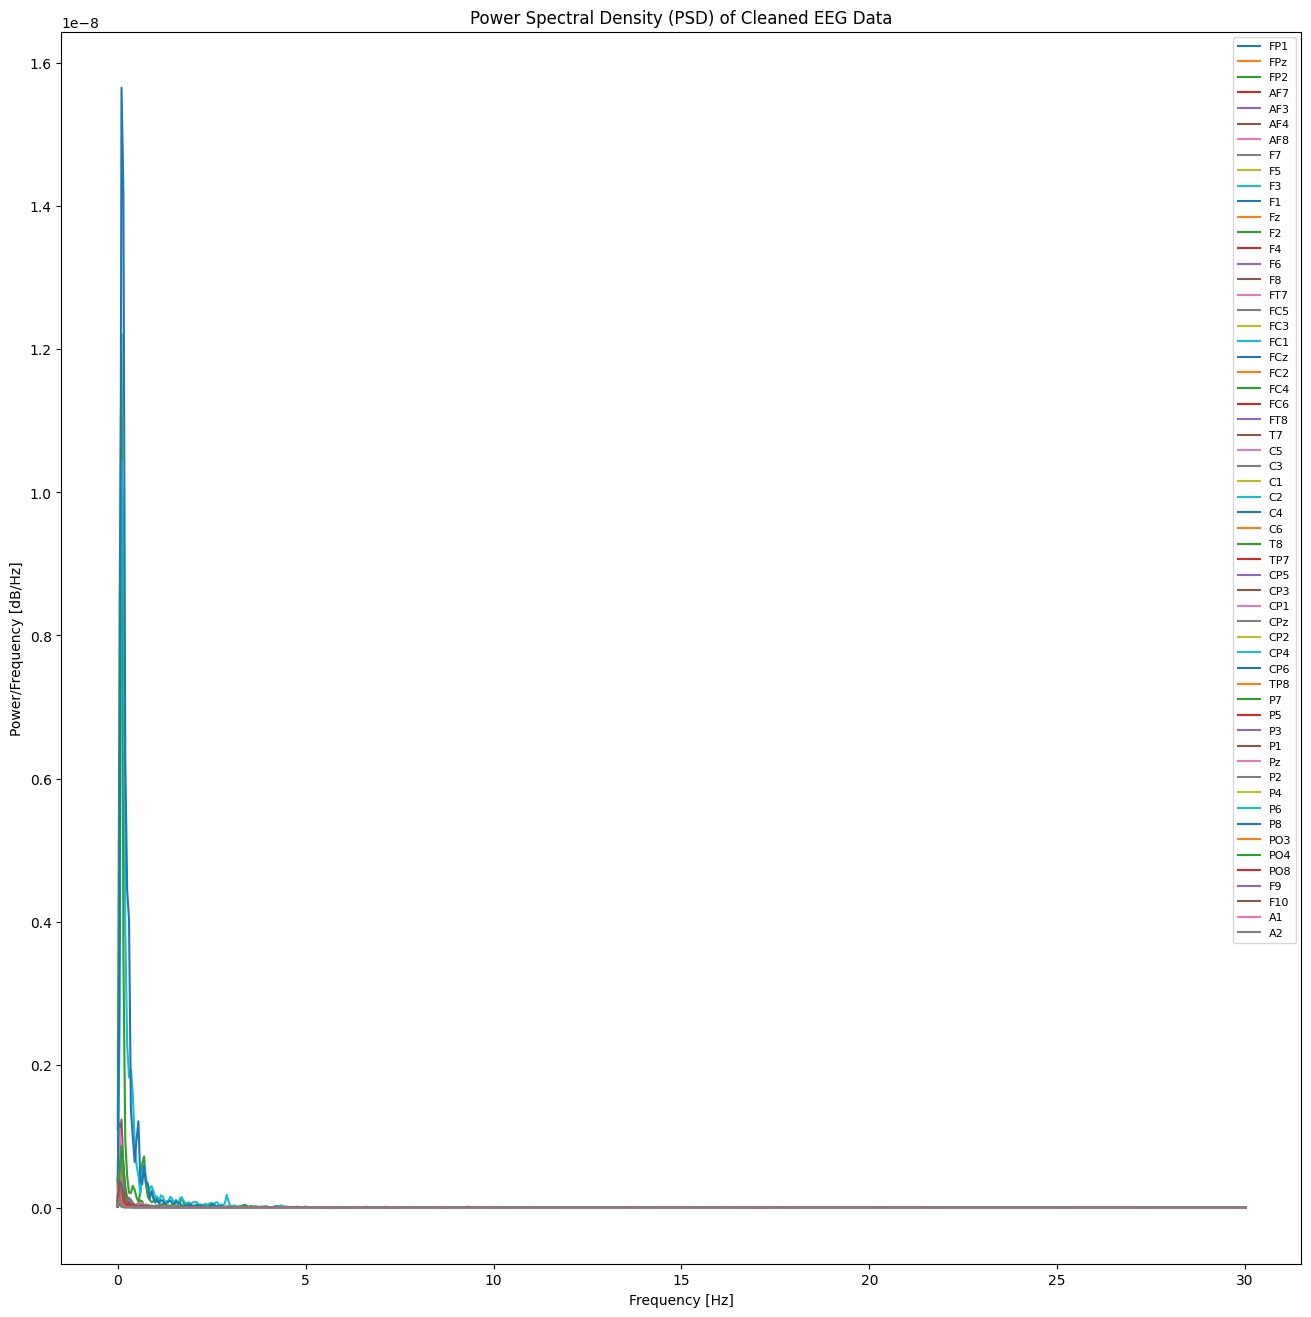

In [31]:
# Plot the all frequency band data (frequency between 0 to 4) from welch PSD using plotly express
# plot_Plotly_Express_PSD(welch_psd_df, 'Power Spectral Density (PSD) of Cleaned EEG Data', {'freq': 'Frequency [Hz]', 'value': 'Power/Frequency [dB/Hz]'})
# Plot the all frequency band data (frequency between 0 to 4) from welch PSD using pyplot
plot_PyPlot_PSD(welch_psd_df, 'Power Spectral Density (PSD) of Cleaned EEG Data', 'Frequency [Hz]', 'Power/Frequency [dB/Hz]')

### Delta Band

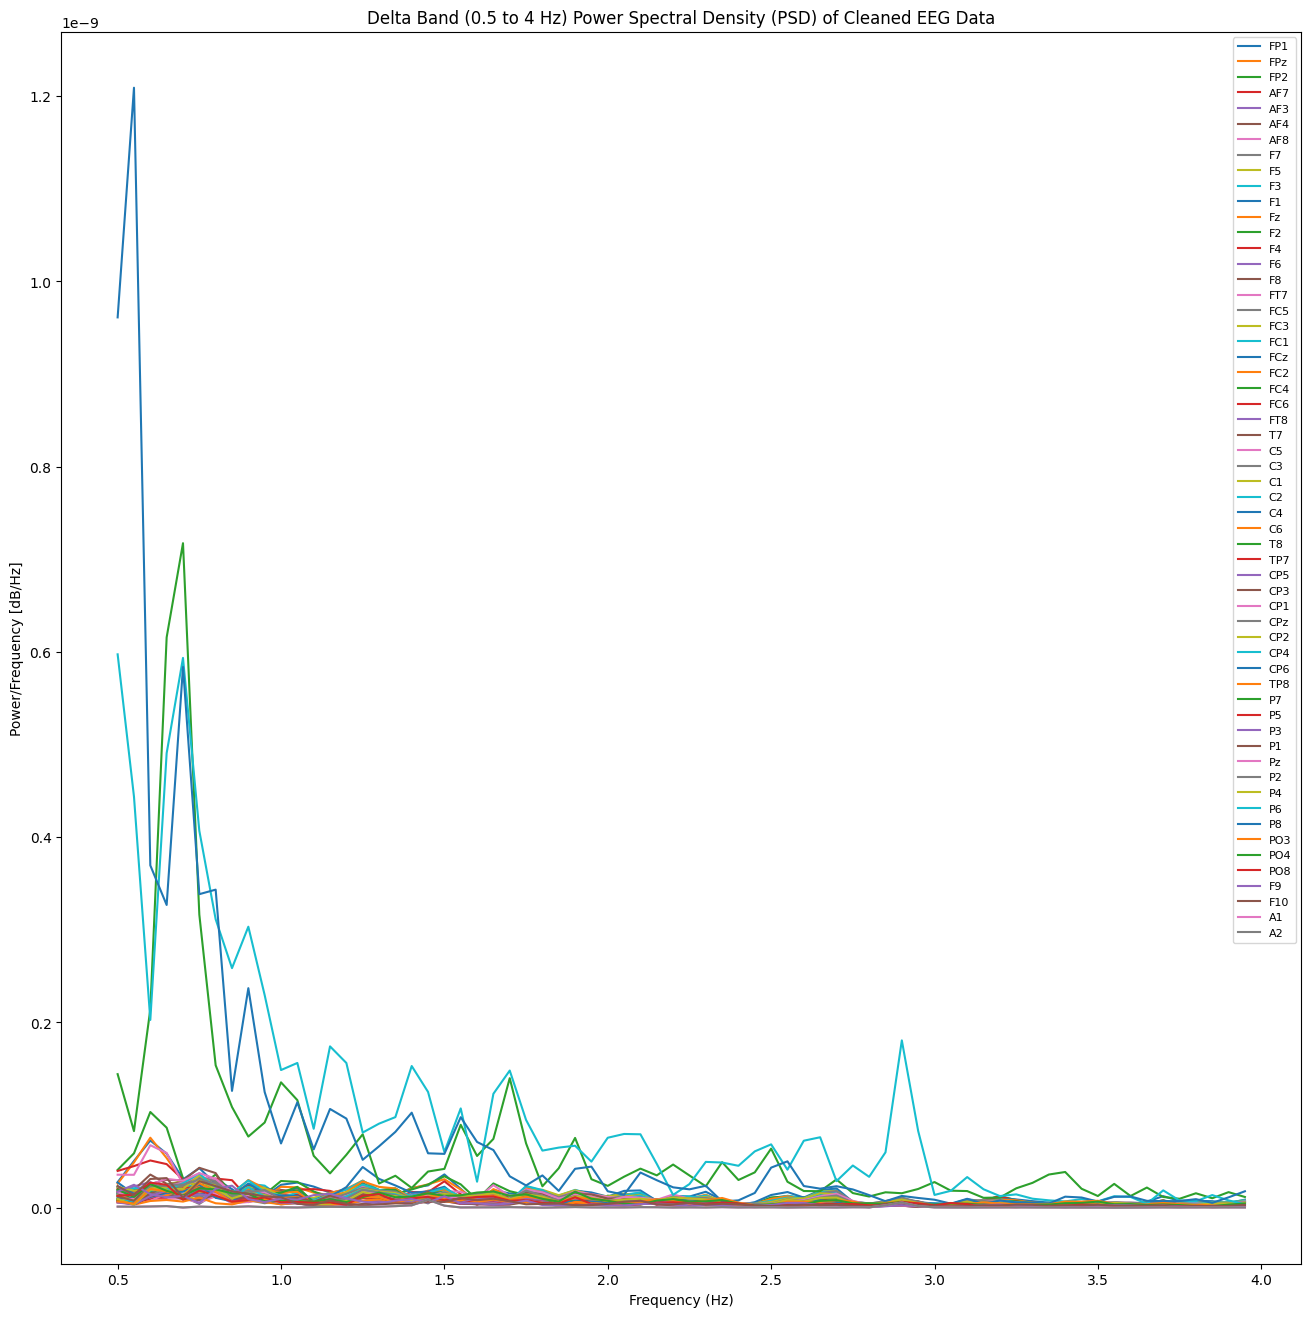

In [32]:
# Plot the delta band data (frequency between 0.5 to 4) from welch PSD using plotly express
# plot_Plotly_Express_PSD(delta_band, 'Delta Band Power Spectral Density (PSD) of Cleaned EEG Data', {'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})

# Plot the delta band data (frequency between 0.5 to 4) from welch PSD using pyplot
plot_PyPlot_PSD(delta_band, 'Delta Band (0.5 to 4 Hz) Power Spectral Density (PSD) of Cleaned EEG Data', 'Frequency (Hz)', 'Power/Frequency [dB/Hz]')

### Theta Band

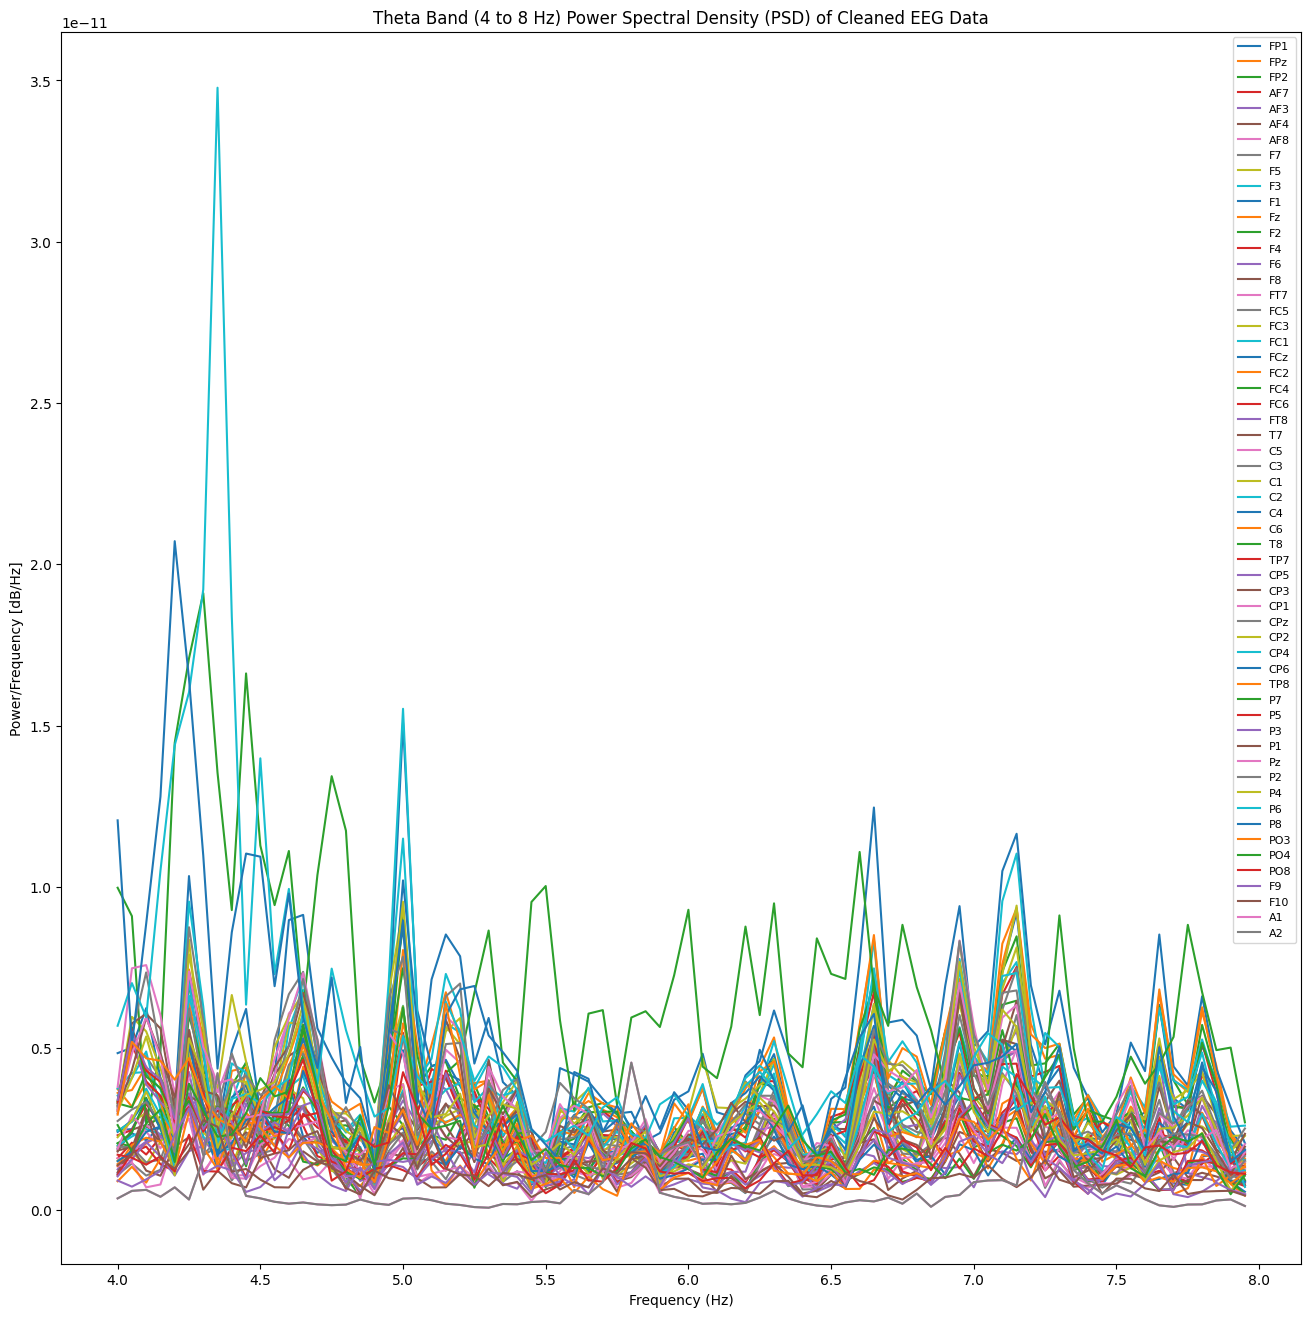

In [33]:
# Plot the theta band data (frequency between 4 to 8) from welch PSD using plotly express
# plot_Plotly_Express_PSD(theta_band, 'Theta Band Power Spectral Density (PSD) of Cleaned EEG Data', {'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})

# Plot the theta band data (frequency between 4 to 8) from welch PSD using pyplot
plot_PyPlot_PSD(theta_band, 'Theta Band (4 to 8 Hz) Power Spectral Density (PSD) of Cleaned EEG Data', 'Frequency (Hz)', 'Power/Frequency [dB/Hz]')

### Alpha Band

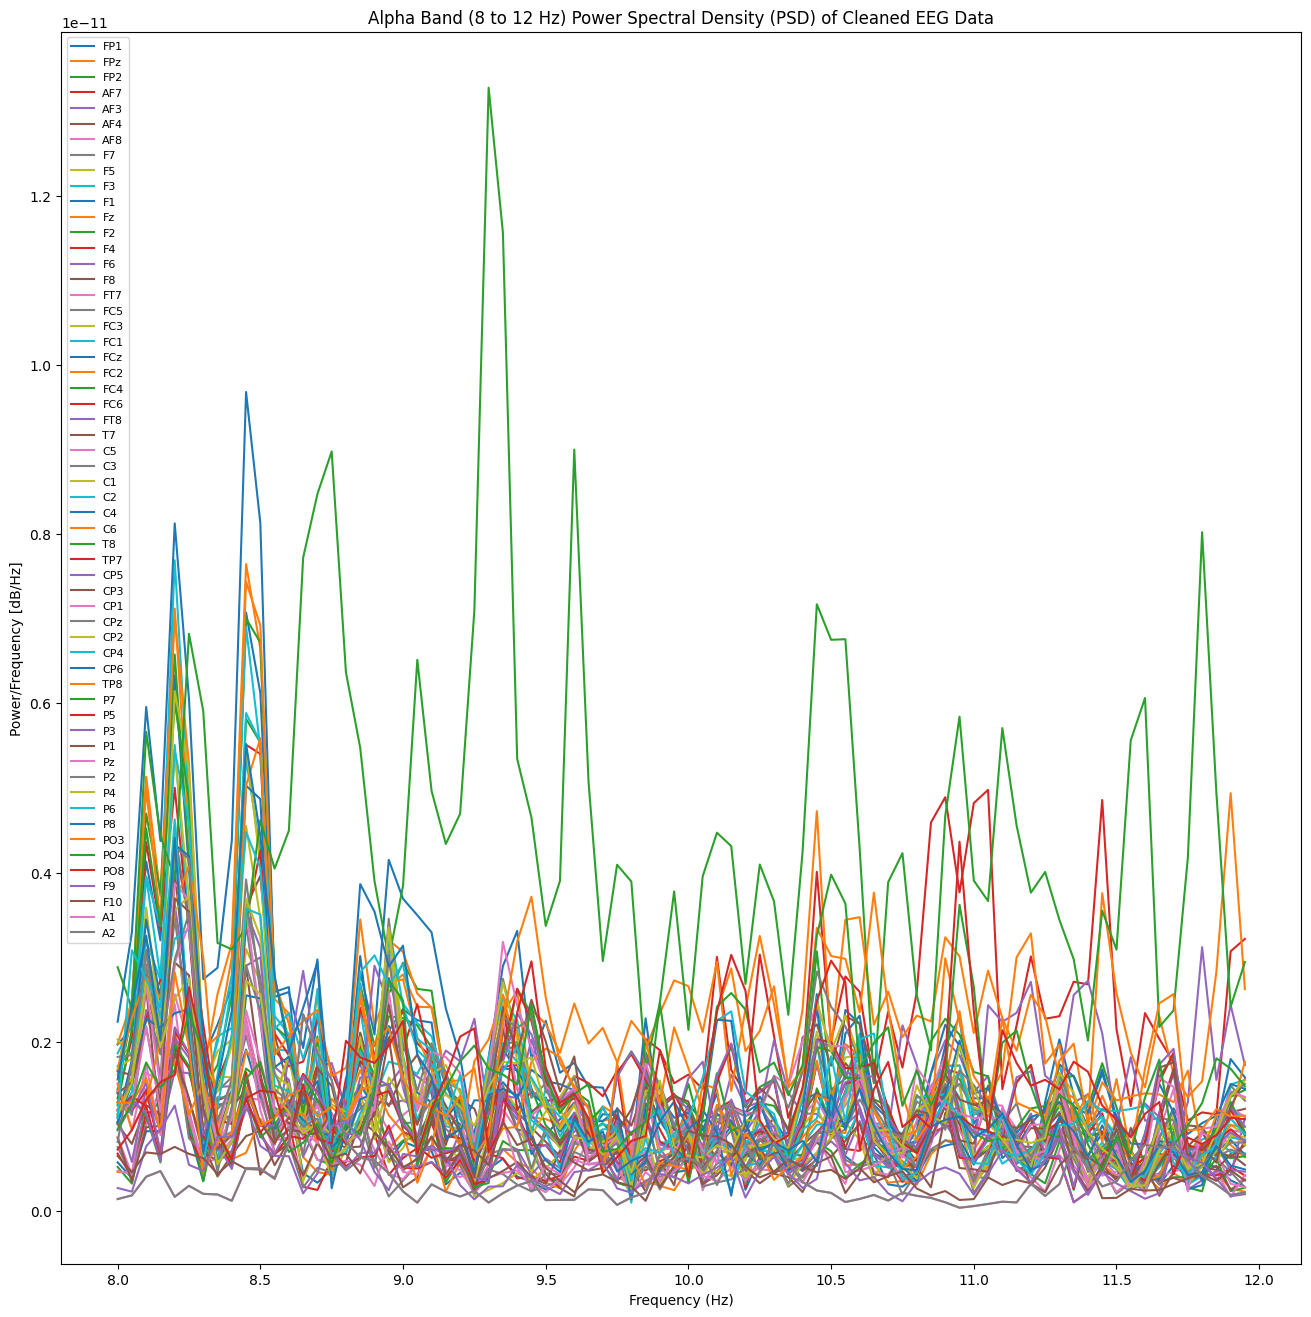

In [34]:
# Plot the alpha band data (frequency between 8 to 12) from welch PSD using plotly express
# plot_Plotly_Express_PSD(alpha_band, 'Alpha Band Power Spectral Density (PSD) of Cleaned EEG Data', {'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})
# Plot the alpha band data (frequency between 8 to 12) from welch PSD using pyplot
plot_PyPlot_PSD(alpha_band, 'Alpha Band (8 to 12 Hz) Power Spectral Density (PSD) of Cleaned EEG Data', 'Frequency (Hz)', 'Power/Frequency [dB/Hz]')

### Beta Band

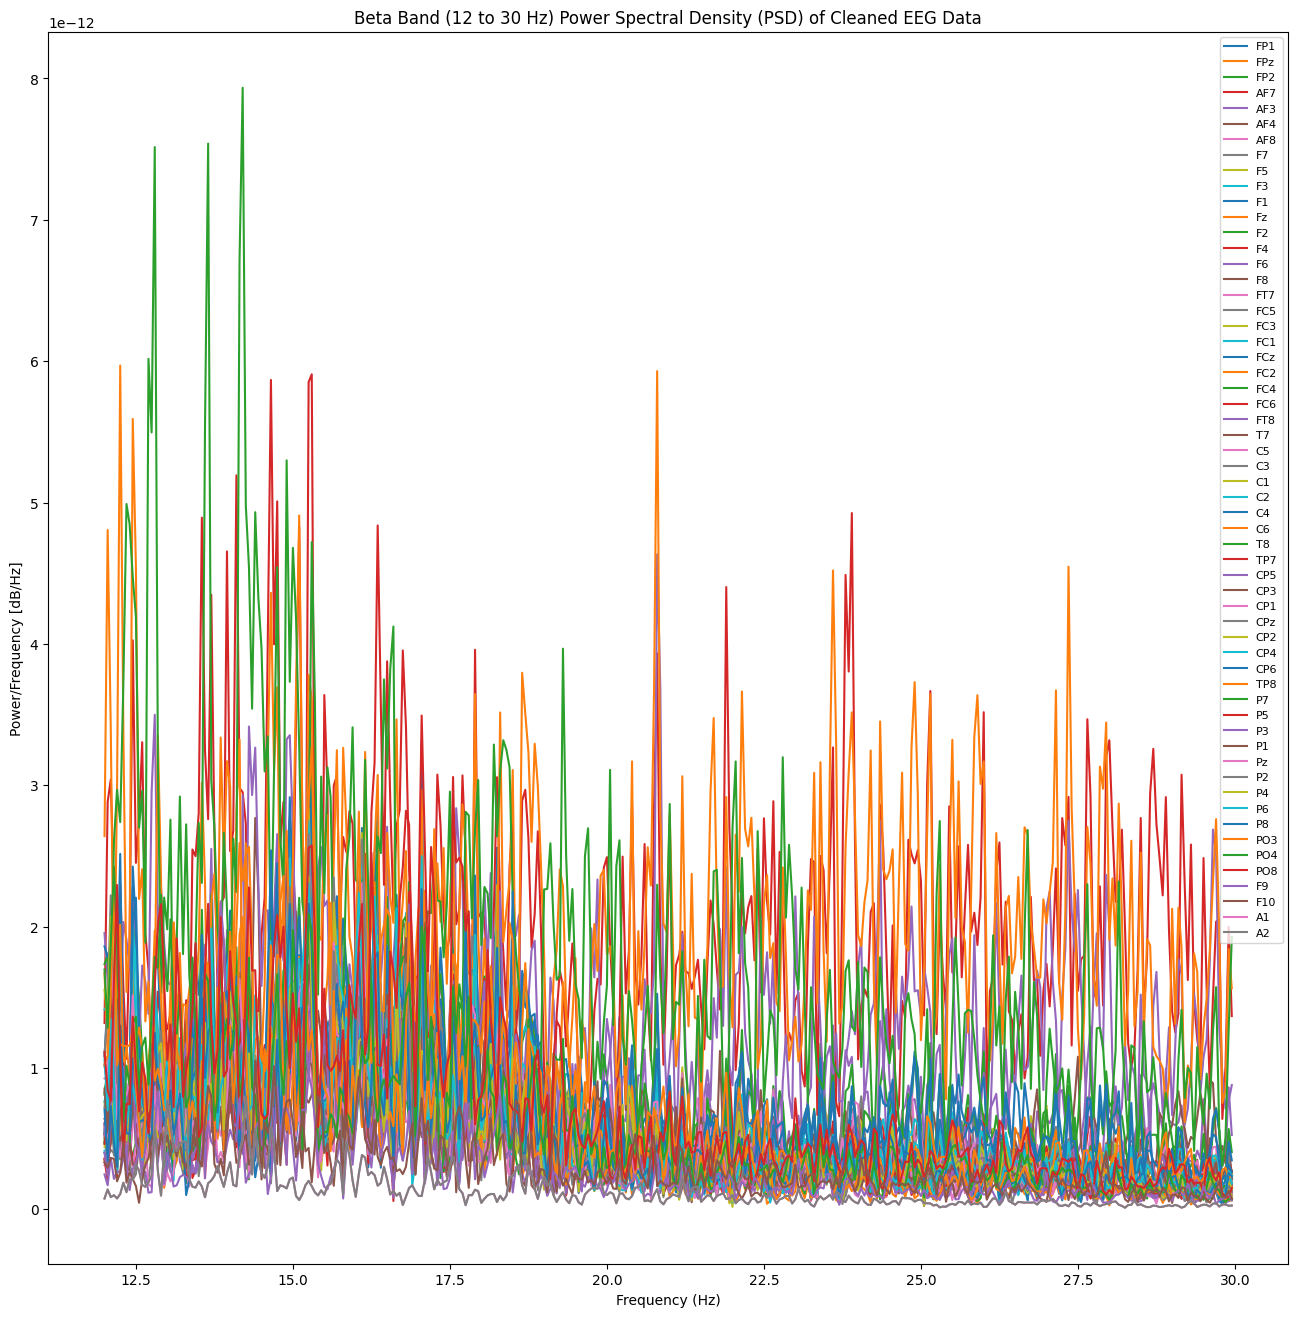

In [35]:
# Plot the beta band data (frequency between 12 to 30) from welch PSD using plotly express
# plot_Plotly_Express_PSD(beta_band, 'Beta Band Power Spectral Density (PSD) of Cleaned EEG Data', {'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})

# Plot the beta band data (frequency between 12 to 30) from welch PSD using pyplot
plot_PyPlot_PSD(beta_band, 'Beta Band (12 to 30 Hz) Power Spectral Density (PSD) of Cleaned EEG Data', 'Frequency (Hz)', 'Power/Frequency [dB/Hz]')

### Gamma Band

In [36]:
# Plot the gamma band data (frequency between > 30) from welch PSD using pyplot
# plot_Plotly_Express_PSD(welch_psd_df, 30, 120, 'Gamma Band Power Spectral Density (PSD) of Cleaned EEG Data', {'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})
# plot_PyPlot_PSD(gamma_band, 'Gamma Band Power Spectral Density (PSD) of Cleaned EEG Data', 'Frequency (Hz)', 'Power/Frequency [dB/Hz]')